In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda import BCW_Explorer
from sklearn import preprocessing

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

In [135]:
eda = BCW_Explorer()

## 1. Data Quality

## 2. Data Analysis

### 2.1 Overview of Variables

In [53]:
print(
    'Attributes:\n\t{0}\n'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('attributes').unique() if x)
    ),
    '\n... where each attribute is summarized by:\n\t{0}'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('summaries').unique() if x != 'label')
    ),
    '\n\n... for a total of 30 features'
)


Attributes:
	radius, texture, circumference, area, smoothness, density, concavity_intensity, concavity_count, symmetry, fractal_dimension
 
... where each attribute is summarized by:
	mean, std, mean_max3 

... for a total of 30 features


---
At first, we should assume that there is correlation between some of the features given the nature of the attributes which they summarize.
* perimiter and area yield
    * radius, smoothness (local variation in radius lengths) and compactness (perimeter^2 / area - 1.0);

We explore whether they significantly correlate in the section 2.2
<br />

### > What is the attribute Fractal Dimension?<br />
Fractal dimension is a measure of how regular the contour of a shape is.<br />
It is approximated by measuring the downward slope of the log of observed perimeter plotted agains the log of a "ruler" size.<br />
Hence, a higher value corresponds to a less regular contour, which in turn means a higher probability of malignancy (Wolberg et al. 1994)


### 2.2 Class Imbalance, Correlation Analysis and Feature Distribution 

In [4]:
def plot_compare_classdistribution(df: pd.DataFrame, summary='mean', ax=None):
    # scales the data
    df = df.apply(preprocessing.scale, axis=0)

    # melts columns' (name, value) pair into two columns
    df =\
        pd.melt(
            pd.concat(
                [
                    df['label'],
                    df.xs(summary, level='summaries', axis=1)
                ],
                axis=1
            ),
            id_vars='label',
            var_name='features',
            value_name='value'
        )

    # plots comparative distribution of classes for each 'mean' feature
    return\
        sns.violinplot(
            ax=ax,
            data=df,
            y="value",
            x="features",
            hue="label",
            inner="quart",
            split=True,
        )


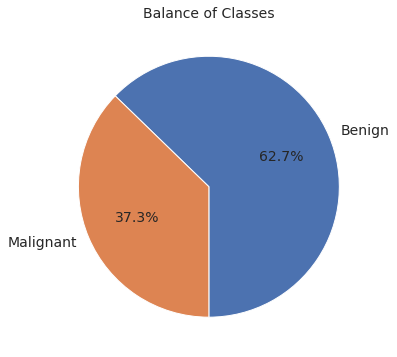

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.set_title('Balance of Classes', fontsize=14)

eda.data['label']\
    .map({1: 'Malignant', 0: 'Benign'})\
    .value_counts()\
    .plot(
        ax=ax,
        kind='pie',
        autopct='%1.1f%%',
        startangle=270,
        fontsize=14,
        label=''
    )

plt.show()

### - Imbalanced Classes
There are almost twice as many benign observations than malignant, which can become an issue while inducing machine learning models. Thus, we must employ a sampling technique.<br />
<br />

<center><img style="margin-bottom:5mm" src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png"><center/>
<center>Figure 1. Approaches to resampling<center/>
<center style="margin-bottom:5mm">Source. https://tinyurl.com/yy2qtbe2<center/>

<p>Before applying any resampling method to our data, we must consider if any redundant features can be removed. This is done by employing correlation analysis of our features<p/>

### - Correlation Analysis

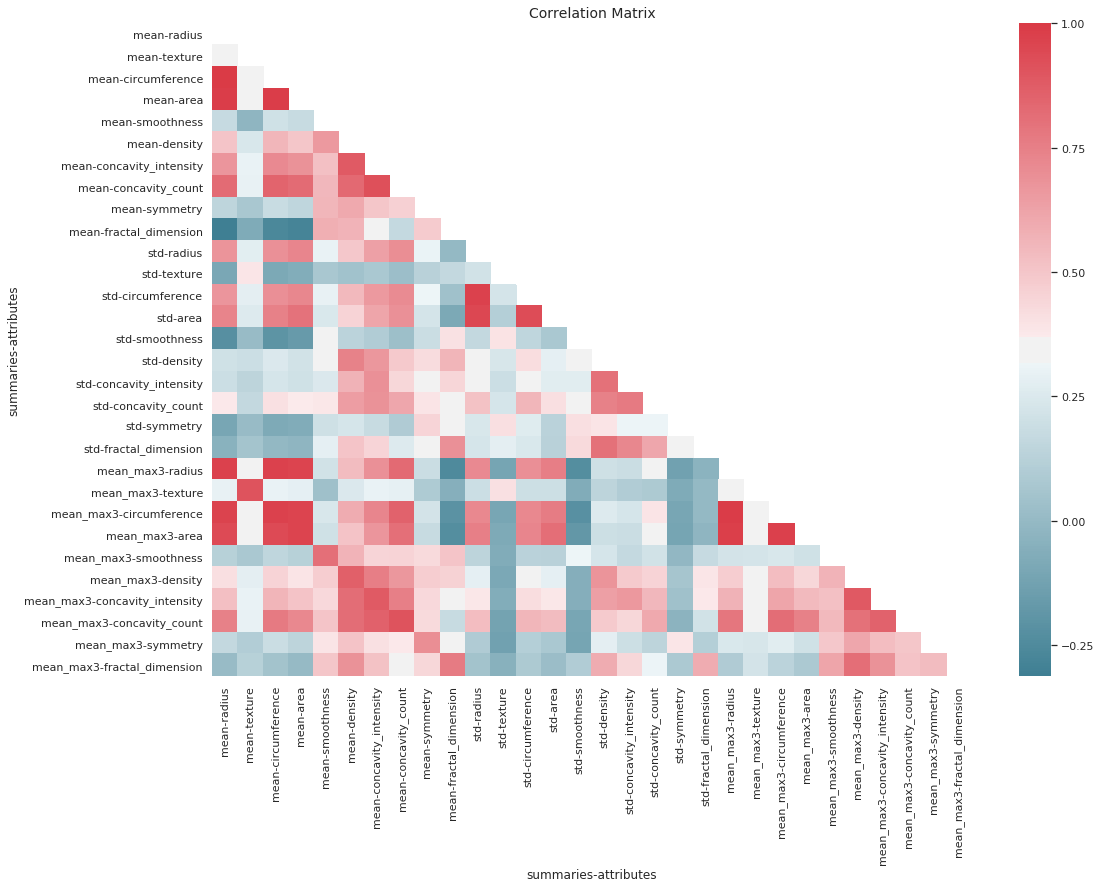

In [54]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(17, 12))
ax.set_title('Correlation Matrix', fontsize=14)

corr = eda.data.drop('label', axis=1).corr()

# generates an upper diagonal mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    ax=ax,
    vmax=1,
    cmap=cmap,
    mask=mask,
    annot=False,
    square=False,
)

plt.show()

### - Feature Distribution

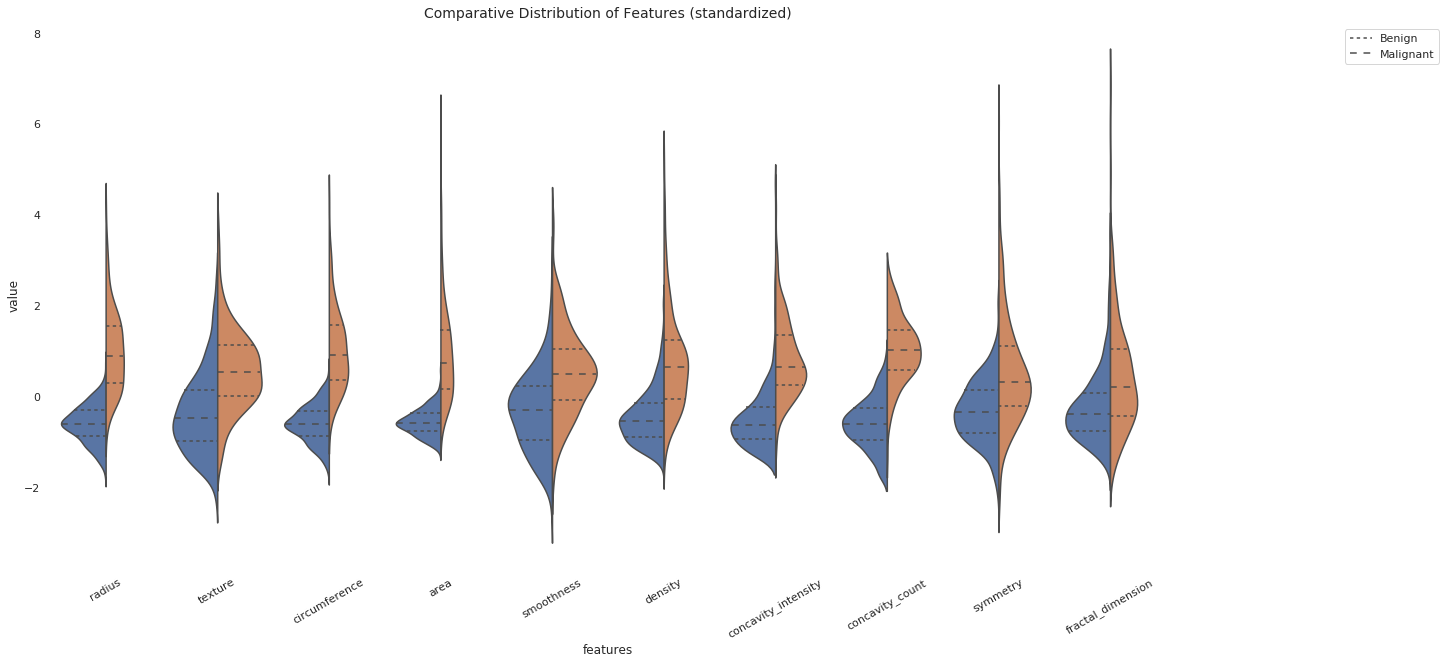

In [65]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Comparative Distribution of Features (standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(eda.data, ax=ax, summary='mean_max3')

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
ax.legend(['Benign', 'Malignant'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [107]:
print('Skewness of features:')
eda.data.skew().sort_values(ascending=False)

Skewness of Features:


summaries  attributes         
std        area                   5.447186
           concavity_intensity    5.110463
           fractal_dimension      3.923969
           circumference          3.443615
           radius                 3.088612
           smoothness             2.314450
           symmetry               2.195133
           density                1.902221
mean_max3  area                   1.859373
           fractal_dimension      1.662579
std        texture                1.646444
mean       area                   1.645732
mean_max3  density                1.473555
std        concavity_count        1.444678
mean_max3  symmetry               1.433928
mean       concavity_intensity    1.401180
           fractal_dimension      1.304489
           density                1.190123
           concavity_count        1.171180
mean_max3  concavity_intensity    1.150237
           circumference          1.128164
           radius                 1.103115
mean       circumferenc

In [199]:
from scipy.stats import boxcox, skew

def transform_skew(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Transforms data with Boxcox transformation
    Keeps the transformation only if it is less skewed than the original
    '''
    skew_transformed = pd.DataFrame()

    for feat in df.drop('label', axis=1):

        data = df.drop('label', axis=1)[feat].values
        posdata = data[data > 0]
        # posdata = eda.data[eda.data[feat]>0][feat]

        x, lmbda = boxcox(posdata, lmbda=None)
        
        transform = np.empty_like(data)
        transform[data > 0] = x
        transform[data == 0] = -1/lmbda

        if abs(skew(transform)) < abs(skew(data)):
            skew_transformed[feat] = transform

        else:
            skew_transformed[feat] = data
    
    skew_transformed.columns =\
        pd.MultiIndex.from_tuples(
            list(skew_transformed.columns),
            names=('summaries', 'attributes')
        )

    return skew_transformed

In [201]:
# print('Skewness of features after boxcox transormation:')
transform_skew(eda.data).skew().sort_values(ascending=False)

summaries  attributes         
std        concavity_count        1.444678
mean       concavity_count        1.171180
mean_max3  concavity_count        0.492616
std        area                   0.058529
           circumference          0.031614
mean_max3  circumference          0.030437
std        radius                 0.030343
mean_max3  radius                 0.029596
           area                   0.026589
           fractal_dimension      0.024883
mean       fractal_dimension      0.013525
std        symmetry               0.008194
mean       circumference          0.006916
           radius                 0.006255
           area                   0.005090
           smoothness             0.002393
mean_max3  smoothness             0.001099
std        density               -0.000043
mean       texture               -0.000115
std        texture               -0.000137
           fractal_dimension     -0.000444
mean       density               -0.001664
mean_max3  texture     

### 2.3 Research Questions